## Star-Galaxy-Quasar Classification (Experiment 1) using Classical ML Algorithms. We are using only photometric features as input to our models.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
np.random.seed(69)
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
sns.set()
# from tqdm.notebook 
import tqdm
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time
import pickle

from sklearn.linear_model import SGDClassifier
# https://towardsdatascience.com/hyperparameter-tuning-for-support-vector-machines-c-and-gamma-parameters-6a5097416167
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve, GridSearchCV


# 1. Create Train/Val/Test Sets

In [2]:
X = np.load("/scratch/srinadb/Foundation/Dataset/Experiment1/X_exp1.npy")
dnnx = np.load("/scratch/srinadb/Foundation//Dataset/Experiment1/dnnx_exp1.npy")
objlist = np.load("/scratch/srinadb/Foundation//Dataset/Experiment1/objlist_exp1.npy")
y = np.load("/scratch/srinadb/Foundation//Dataset/Experiment1/y_exp1.npy", allow_pickle=True)

y, label_strings = pd.factorize(y,sort=True)
# y = to_categorical(y)
print('\n')
print(label_strings)




['GALAXY' 'QSO' 'STAR']


In [3]:
zipX = list(zip(X, dnnx))
zipy = list(zip(y, objlist))

zipX_train, zipX_test, zipy_train, zipy_test = train_test_split(zipX, zipy, test_size = 0.125,random_state=42)
zipX_train, zipX_val, zipy_train, zipy_val = train_test_split(zipX_train, zipy_train, test_size = 0.1428, random_state=42)

X_train, dnnx_train = zip(*zipX_train)
X_val, dnnx_val = zip(*zipX_val)
X_test, dnnx_test = zip(*zipX_test)

y_train, objlist_train = zip(*zipy_train)
y_val, objlist_val = zip(*zipy_val)
y_test, objlist_test = zip(*zipy_test)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

dnnx_train = np.array(dnnx_train)
dnnx_val = np.array(dnnx_val)
dnnx_test = np.array(dnnx_test)

y_train = np.array(y_train)
objlist_train = np.array(objlist_train)
y_val = np.array(y_val)
objlist_val = np.array(objlist_val)
y_test = np.array(y_test)
objlist_test = np.array(objlist_test)


del(zipX,zipX_test,zipX_train,zipX_val, X, zipy, zipy_test, zipy_train, zipy_val, objlist)

In [4]:
print(dnnx_train.shape)
print(dnnx_val.shape)
print(dnnx_test.shape)

(180011, 24)
(29988, 24)
(30000, 24)


In [5]:
def get_metrics(y_pred, y_test, labels, to_print=True):
    correct_labels = np.where(y_pred==y_test)[0]
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred,average='macro')
    recall = metrics.recall_score(y_test, y_pred,average='macro')
    f1score = metrics.f1_score(y_test, y_pred,average='macro')
    # rocscore = metrics.roc_auc_score(y_test, y_pred,average='micro',multi_class="ovo")
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)  
    classification_report = metrics.classification_report(y_test, y_pred)

    if to_print:
        print("Identified {} correct labels out of {} labels".format(len(correct_labels), y_test.shape[0]))
        print("Accuracy:",accuracy)
        print("Precision:",precision)
        print("Recall:",recall)
        print("F1 Score:",f1score)
        # print("ROC AUC Score:",rocscore)
        print(f"Labels are: {labels}")
        print("Confusion Matrix:\n", confusion_matrix)
        print("Classification_Report:\n", classification_report)

    return (correct_labels, accuracy, precision, recall, confusion_matrix, classification_report)

In [6]:
def plot_model_change(history,fname="output/time.pdf"):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'],label="Training Acc")
    plt.plot(history.history['val_accuracy'],label="Val Acc")
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'],label="Training Loss")
    plt.plot(history.history['val_loss'],label="Val Loss")
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.savefig(fname)
    plt.show()

In [7]:
dnnx_train = np.vstack((dnnx_train, dnnx_val))
y_train = np.hstack((y_train, y_val))

print(dnnx_train.shape)
print(y_train.shape)

(209999, 24)
(209999,)


# ML Algorithms

## DT Classifier

In [8]:
tuning_parameters_dt = {'criterion': ['gini', 'entropy', 'log_loss'],'max_depth':[5, 10, 50, 100], 'min_samples_split':[5, 10, 50, 100]}
# tuning_parameters_dt = {'criterion': ['gini', 'entropy', 'log_loss'],'max_depth':[10], 'min_samples_split':[10]}
DT = GridSearchCV(DecisionTreeClassifier(random_state=0), tuning_parameters_dt, cv=3, scoring='accuracy', return_train_score=True)
DT.fit(dnnx_train, y_train)

# Printing the best parameters
print(DT.best_estimator_)
print(DT.score(dnnx_train, y_train))
print(DT.score(dnnx_test, y_test))


DecisionTreeClassifier(criterion='entropy', max_depth=50, min_samples_split=100,
                       random_state=0)
0.9227472511773865
0.9007666666666667


In [9]:
# Selecting the optimal parameters

best_criterion_dt = DT.best_estimator_.criterion
best_max_depth_dt = DT.best_estimator_.max_depth
best_min_samples_split_dt = DT.best_estimator_.min_samples_split

# Retraining the model with best hyper parameters
tuning_parameters_dt = {'criterion': [best_criterion_dt],'max_depth':[best_max_depth_dt], 'min_samples_split':[best_min_samples_split_dt]}
DT = GridSearchCV(DecisionTreeClassifier(random_state=0), tuning_parameters_dt, cv=3, scoring='accuracy', return_train_score=True)
DT.fit(dnnx_train, y_train)


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['entropy'], 'max_depth': [50],
                         'min_samples_split': [100]},
             return_train_score=True, scoring='accuracy')

In [10]:
y_test_pred_dt = DT.predict_proba(dnnx_test)
y_test_pred_dt = np.argmax(y_test_pred_dt, axis=1)

In [11]:
y_test

array([2, 2, 1, ..., 2, 2, 1])

In [12]:
print(get_metrics(y_test_pred_dt, y_test, label_strings))

Identified 27023 correct labels out of 30000 labels
Accuracy: 0.9007666666666667
Precision: 0.9010029793199804
Recall: 0.9007367736661266
F1 Score: 0.9007985384840183
Labels are: ['GALAXY' 'QSO' 'STAR']
Confusion Matrix:
 [[9342  478  200]
 [ 486 8827  688]
 [ 236  889 8854]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93     10020
           1       0.87      0.88      0.87     10001
           2       0.91      0.89      0.90      9979

    accuracy                           0.90     30000
   macro avg       0.90      0.90      0.90     30000
weighted avg       0.90      0.90      0.90     30000

(array([    0,     1,     2, ..., 29997, 29998, 29999]), 0.9007666666666667, 0.9010029793199804, 0.9007367736661266, array([[9342,  478,  200],
       [ 486, 8827,  688],
       [ 236,  889, 8854]]), '              precision    recall  f1-score   support\n\n           0       0.93      0.93      0.93     10020\n     

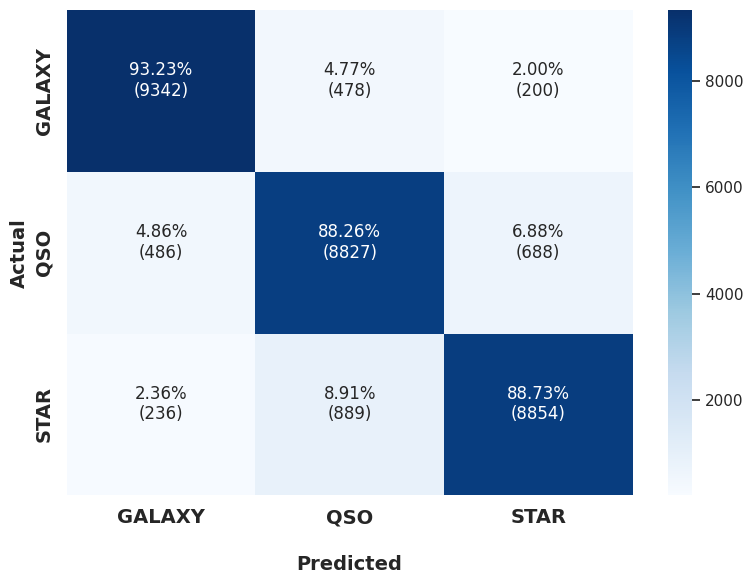

In [13]:
# https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#google_vignette
# fig = plt.figure()
cf_matrix = metrics.confusion_matrix(y_test, y_test_pred_dt)
cf_matrix_percentage = metrics.confusion_matrix(y_test, y_test_pred_dt, normalize='true')
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_percentage.flatten()]
labels = [f"{v1}\n({v2})\n" for v1, v2 in
          zip(group_percentages,group_counts)]
labels = np.asarray(labels).reshape(3,3)
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the size as needed

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('\nPredicted', fontsize=14, weight='bold')
ax.set_ylabel('Actual', fontsize=14, weight='bold');
ax.xaxis.set_ticklabels(['GALAXY', 'QSO', 'STAR'], fontsize=14, weight='bold')
ax.yaxis.set_ticklabels(['GALAXY', 'QSO', 'STAR'], fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig("ml_pf_classifiers/EX1_SGQ_DT_CM.png")
plt.show()
plt.close()

In [14]:
Pkl_Filename_dt = "ml_pf_classifiers/EX1_SGQ_DT_Model.pkl"  

with open(Pkl_Filename_dt, 'wb') as file:  
    pickle.dump(DT, file)


## RF Classifier

In [15]:
tuning_parameters_rf = {'n_estimators':[50, 100, 200], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [5, 10, 50, 100], 'min_samples_split':[5, 10, 50, 100]}
# tuning_parameters_rf = {'n_estimators':[200], 'criterion': ['entropy'], 'max_depth': [50], 'min_samples_split':[5]}
RF = GridSearchCV(RandomForestClassifier(random_state=0), tuning_parameters_rf, cv=3, scoring='accuracy', n_jobs=-1, return_train_score=True)
RF.fit(dnnx_train, y_train)

# Printing the best parameters
print(RF.best_estimator_)
print(RF.score(dnnx_train, y_train))
print(RF.score(dnnx_test, y_test))


RandomForestClassifier(max_depth=50, min_samples_split=5, n_estimators=200,
                       random_state=0)
0.9980380858956471
0.9221666666666667


In [16]:
# Selecting the optimal parameters
best_n_estimators_rf = RF.best_estimator_.n_estimators
best_criterion_rf = RF.best_estimator_.criterion
best_max_depth_rf = RF.best_estimator_.max_depth
best_min_samples_split_rf = RF.best_estimator_.min_samples_split

# Retraining the model with best hyper parameters
tuning_parameters_rf = {'n_estimators': [best_n_estimators_rf], 'criterion': [best_criterion_rf], 'max_depth':[best_max_depth_rf], 'min_samples_split':[best_min_samples_split_rf]}
RF = GridSearchCV(RandomForestClassifier(random_state=0), tuning_parameters_rf, cv=3, scoring='accuracy', n_jobs=-1, return_train_score=True)
RF.fit(dnnx_train, y_train)


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [50],
                         'min_samples_split': [5], 'n_estimators': [200]},
             return_train_score=True, scoring='accuracy')

In [17]:
y_test_pred_rf = RF.predict_proba(dnnx_test)
y_test_pred_rf = np.argmax(y_test_pred_rf, axis=1)

In [18]:
print(get_metrics(y_test_pred_rf, y_test, label_strings))

Identified 27665 correct labels out of 30000 labels
Accuracy: 0.9221666666666667
Precision: 0.9230473520012796
Recall: 0.9221290832760682
F1 Score: 0.9222422742949273
Labels are: ['GALAXY' 'QSO' 'STAR']
Confusion Matrix:
 [[9524  366  130]
 [ 386 9206  409]
 [ 181  863 8935]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95     10020
           1       0.88      0.92      0.90     10001
           2       0.94      0.90      0.92      9979

    accuracy                           0.92     30000
   macro avg       0.92      0.92      0.92     30000
weighted avg       0.92      0.92      0.92     30000

(array([    0,     1,     2, ..., 29997, 29998, 29999]), 0.9221666666666667, 0.9230473520012796, 0.9221290832760682, array([[9524,  366,  130],
       [ 386, 9206,  409],
       [ 181,  863, 8935]]), '              precision    recall  f1-score   support\n\n           0       0.94      0.95      0.95     10020\n     

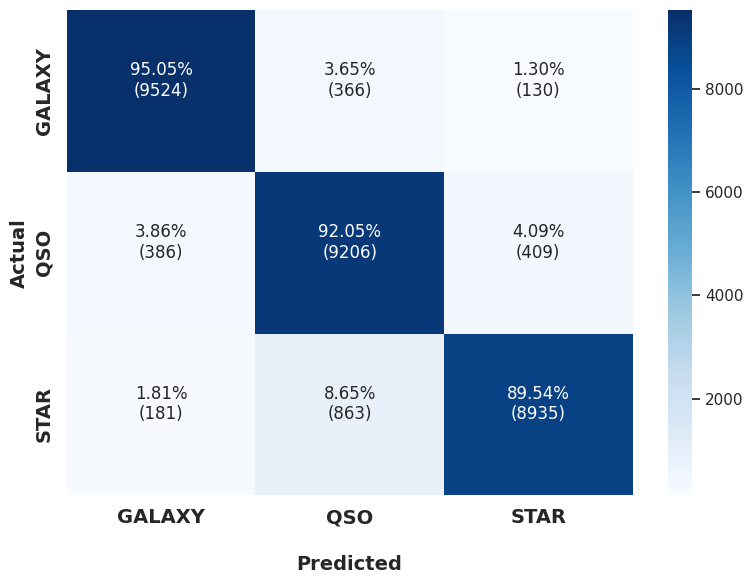

In [19]:
# https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#google_vignette
# fig = plt.figure()
cf_matrix = metrics.confusion_matrix(y_test, y_test_pred_rf)
cf_matrix_percentage = metrics.confusion_matrix(y_test, y_test_pred_rf, normalize='true')
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_percentage.flatten()]
labels = [f"{v1}\n({v2})\n" for v1, v2 in
          zip(group_percentages,group_counts)]
labels = np.asarray(labels).reshape(3,3)
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the size as needed

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('\nPredicted', fontsize=14, weight='bold')
ax.set_ylabel('Actual', fontsize=14, weight='bold');
ax.xaxis.set_ticklabels(['GALAXY', 'QSO', 'STAR'], fontsize=14, weight='bold')
ax.yaxis.set_ticklabels(['GALAXY', 'QSO', 'STAR'], fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig("ml_pf_classifiers/EX1_SGQ_RF_CM.png")
plt.show()
plt.close()

In [20]:
Pkl_Filename_rf = "ml_pf_classifiers/EX1_SGQ_RF_Model.pkl"  

with open(Pkl_Filename_rf, 'wb') as file:  
    pickle.dump(RF, file)


## GBDT Classifier

In [21]:
tuning_parameters_gbdt = {'n_estimators':[5, 10, 50, 100], 'max_depth': [5, 10, 50, 100]}
# tuning_parameters_gbdt = {'n_estimators':[100], 'max_depth': [50]}
GBDT = GridSearchCV(XGBClassifier(random_state=0), tuning_parameters_gbdt, cv = 3, scoring='accuracy', n_jobs=-1, return_train_score=True)
GBDT.fit(dnnx_train, y_train)

# Printing the best parameters
print(GBDT.best_estimator_)
print(GBDT.score(dnnx_train, y_train))
print(GBDT.score(dnnx_test, y_test))


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=50, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
1.0
0.9280666666666667


In [22]:
# Selecting the optimal parameters
# best_loss_gbdt = GBDT.best_estimator_.loss
best_n_estimators_gbdt = GBDT.best_estimator_.n_estimators
best_max_depth_gbdt = GBDT.best_estimator_.max_depth
# best_min_samples_split_gbdt = GBDT.best_estimator_.min_samples_split

# Retraining the model with best hyper parameters
tuning_parameters_gbdt = {'n_estimators':[best_n_estimators_gbdt],'max_depth':[best_max_depth_gbdt]}
GBDT = GridSearchCV(XGBClassifier(random_state=0), tuning_parameters_gbdt, cv=3, scoring='accuracy', n_jobs=-1, return_train_score=True)
GBDT.fit(dnnx_train, y_train)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             n_jobs=-1, param_grid={'max_depth': [50], 'n_estimators': [100]},
             return_train_score=True, scoring='accuracy')

In [23]:
y_test_pred_gbdt = GBDT.predict_proba(dnnx_test)
y_test_pred_gbdt = np.argmax(y_test_pred_gbdt, axis=1)

In [24]:
print(get_metrics(y_test_pred_gbdt, y_test,label_strings))

Identified 27842 correct labels out of 30000 labels
Accuracy: 0.9280666666666667
Precision: 0.9283815109224546
Recall: 0.9280401824169449
F1 Score: 0.9281185071035662
Labels are: ['GALAXY' 'QSO' 'STAR']
Confusion Matrix:
 [[9546  335  139]
 [ 338 9183  480]
 [ 139  727 9113]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     10020
           1       0.90      0.92      0.91     10001
           2       0.94      0.91      0.92      9979

    accuracy                           0.93     30000
   macro avg       0.93      0.93      0.93     30000
weighted avg       0.93      0.93      0.93     30000

(array([    0,     1,     2, ..., 29997, 29998, 29999]), 0.9280666666666667, 0.9283815109224546, 0.9280401824169449, array([[9546,  335,  139],
       [ 338, 9183,  480],
       [ 139,  727, 9113]]), '              precision    recall  f1-score   support\n\n           0       0.95      0.95      0.95     10020\n     

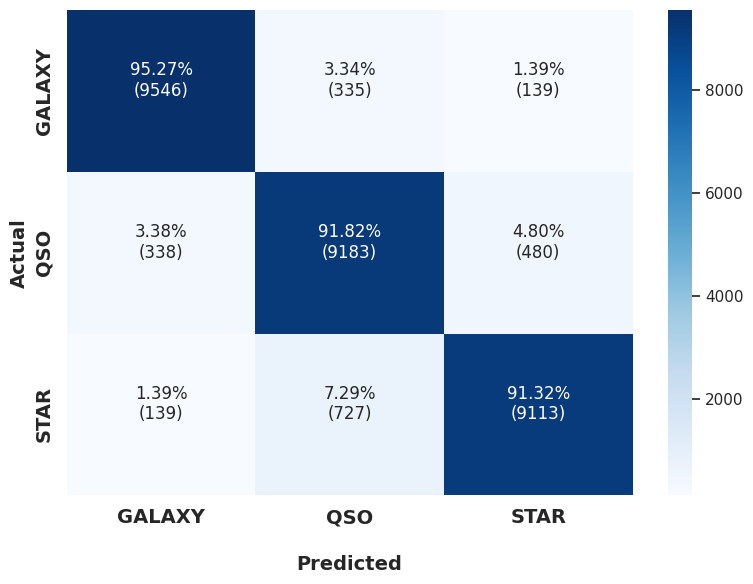

In [25]:
# https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#google_vignette
# fig = plt.figure()

cf_matrix = metrics.confusion_matrix(y_test, y_test_pred_gbdt)
cf_matrix_percentage = metrics.confusion_matrix(y_test, y_test_pred_gbdt, normalize='true')
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_percentage.flatten()]
labels = [f"{v1}\n({v2})\n" for v1, v2 in
          zip(group_percentages,group_counts)]
labels = np.asarray(labels).reshape(3,3)
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the size as needed

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('\nPredicted', fontsize=14, weight='bold')
ax.set_ylabel('Actual', fontsize=14, weight='bold');
ax.xaxis.set_ticklabels(['GALAXY', 'QSO', 'STAR'], fontsize=14, weight='bold')
ax.yaxis.set_ticklabels(['GALAXY', 'QSO', 'STAR'], fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig("ml_pf_classifiers/EX1_SGQ_GBDT_CM.png")
plt.show()
plt.close()

In [26]:
Pkl_Filename_gbdt = "ml_pf_classifiers/EX1_SGQ_GBDT_Model.pkl"  

with open(Pkl_Filename_gbdt, 'wb') as file:  
    pickle.dump(GBDT, file)
